In [1]:
import signac as sg
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gamma

In [2]:
project = sg.get_project()

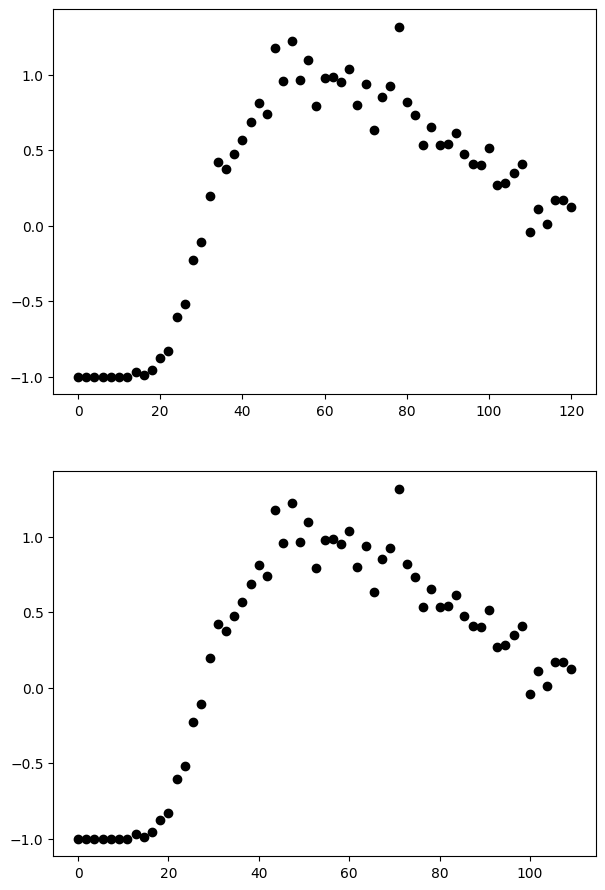

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(7,11))
c = 1.42
# for job in project.find_jobs({'fire_prob': 0.17}):
for job in project:
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
        # final_approx = np.mean(final_approx_vec)
        init = N_tot_vec[0,0]
        # y = np.mean(final_approx_vec) / init
        err = np.std(final_approx_vec/init, ddof=1)
        diff_vec = final_approx_vec - init
        y_vec = diff_vec / init
        y = np.mean(y_vec)
        err = np.std(y_vec, ddof=1)
        axs[0].scatter(job.sp.weibull_b, y, color='k')
        # axs[0].errorbar(job.sp.fire_prob, y, yerr=err, color='k', fmt='o')
        # axs[0].set_ylim(-0.5, 6)
        fri = job.sp.weibull_b * gamma(1+1/c)
        axs[1].scatter(fri, y, color='k')
        # axs[1].errorbar(fri, y, yerr=err, color='k', fmt='o')

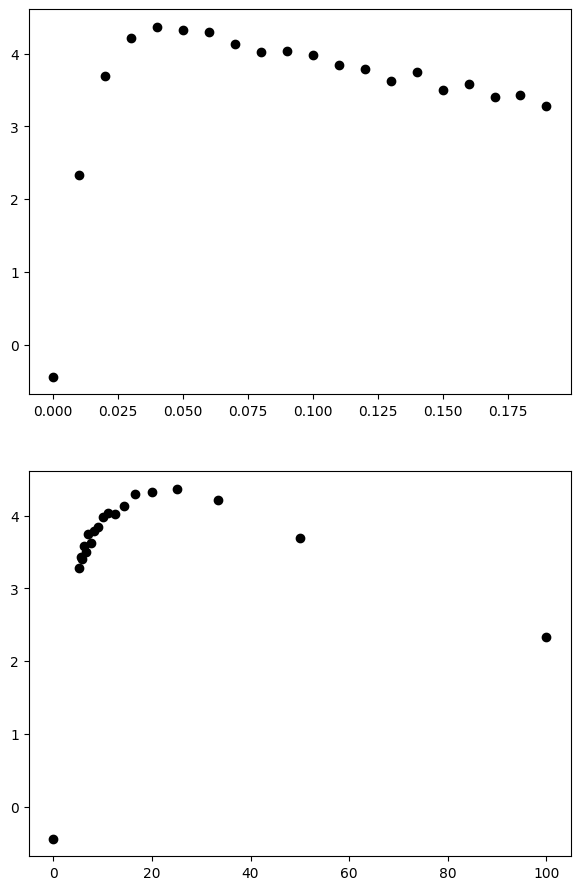

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(7,11))
for job in project:
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,:-20], axis=1)
        # final_approx = np.mean(final_approx_vec)
        init = N_tot_vec[0,0]
        # y = np.mean(final_approx_vec) / init
        # err = np.std(final_approx_vec/init, ddof=1)
        diff_vec = final_approx_vec - init
        y_vec = diff_vec / init
        y = np.mean(y_vec)
        err = np.std(y_vec, ddof=1)
        axs[0].scatter(job.sp.fire_prob, y, color='k')
        # axs[0].errorbar(job.sp.fire_prob, y, yerr=err, color='k', fmt='o')
        # axs[0].set_ylim(-0.5, 6)
        fri = 0 if job.sp.fire_prob==0 else 1/job.sp.fire_prob
        axs[1].scatter(fri, y, color='k')
        # axs[1].errorbar(fri, y, yerr=err, color='k', fmt='o')

(0.0, 20.0)

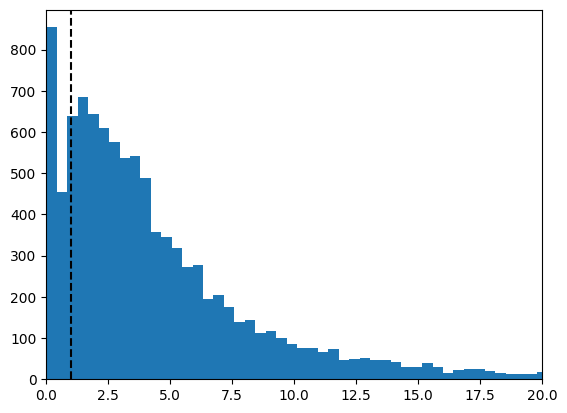

In [82]:
plt.hist(final_approx_vec/init, bins=400);
plt.axvline(1, ls='--', c='k')
plt.xlim(0,20)

In [41]:
for job in project.find_jobs({'weibull_b': 40}):
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
        y_vec = final_approx_vec
        census_t = np.array(data['census_t'])

(-100.0, 5000.0)

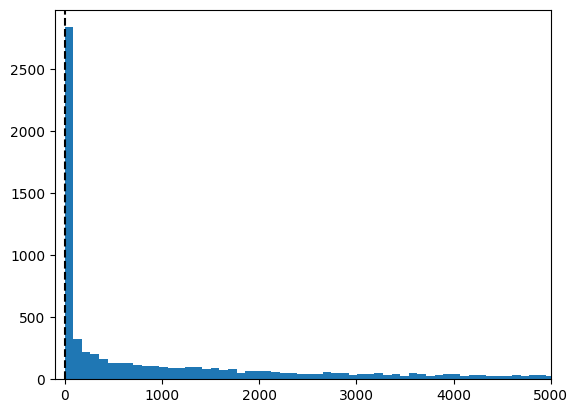

In [114]:
hist = plt.hist(y_vec, bins=10000);
# hist = plt.hist(y_vec, bins=100);
plt.axvline(0, ls='--', c='k')
plt.xlim(-100,5000)

In [79]:
hist

(array([3.165e+03, 4.190e+02, 2.970e+02, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([0.00000000e+00, 1.76970400e+02, 3.53940800e+02, ...,
        8.84498059e+05, 8.84675030e+05, 8.84852000e+05]),
 <BarContainer object of 5000 artists>)

In [107]:
census_yrs

array([  1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,  25,
        27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,  51,
        53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,  77,
        79,  81,  83,  85,  87,  89,  91,  93,  95,  97,  99, 101, 103,
       105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129,
       131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151])

(-480.0, 24000.0)

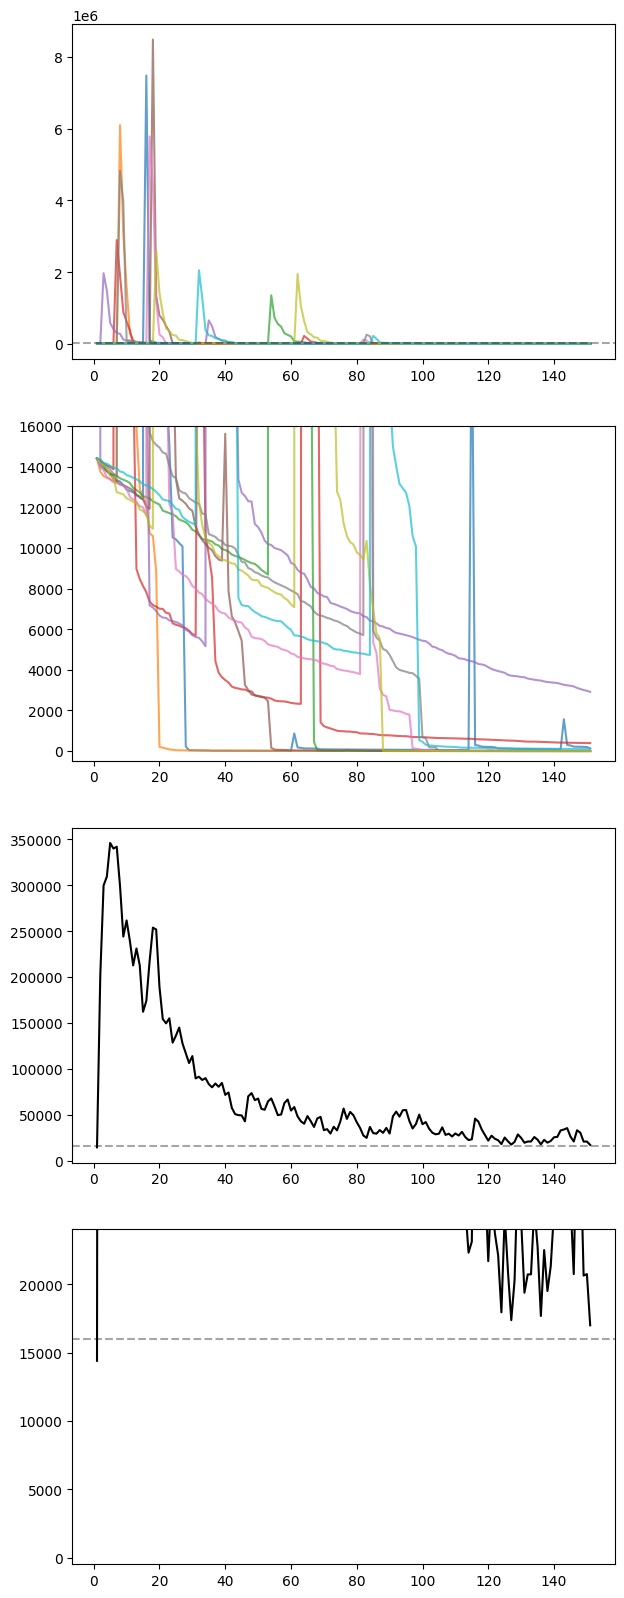

In [42]:
fig, axs = plt.subplots(4, 1, figsize=(7,20))
for N in N_tot_vec[::int(len(N_tot_vec)/10)]:
    axs[0].plot(census_t,N, alpha=0.7)
    axs[1].plot(census_t,N, alpha=0.7)
K_adult = 16000
axs[0].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[1].set_ylim(-0.03*K_adult,K_adult)
#print(len(model.N_tot_vec.mean(axis=0)))
axs[2].plot(census_t, N_tot_vec.mean(axis=0), c='k')
axs[2].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[3].plot(census_t, N_tot_vec.mean(axis=0), c='k')
axs[3].axhline(K_adult, ls='--', c='k', alpha=0.35)
axs[3].set_ylim(-0.03*K_adult,1.5*K_adult)

In [46]:
N_tot_vec

array([[14400., 14041., 13908., ...,   203.,   198.,   133.],
       [14400., 14257., 14065., ...,  6451.,  6289.,  6257.],
       [14400., 14359., 13896., ...,  4839.,  4736.,  4667.],
       ...,
       [14400., 14277., 14078., ...,   286.,   285.,   263.],
       [14400., 14350., 13929., ...,  8002.,  7915.,  7758.],
       [14400., 14284., 14202., ...,  4272.,  4220.,  4186.]])